### Repeat of MLP
January 27 2020 

In [1]:
# load libs
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
# load mnist
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.dtype, y.dtype, X.shape, y.shape, X.max(), X.min(), y.max(), y.min())

# preprocess
X = X.T / 255.0
Y = OneHotEncoder().fit_transform(y.reshape(-1, 1).astype('int32')).toarray().T # one hot labeld
print(X.shape, Y.shape)

float64 object (70000, 784) (70000,) 255.0 0.0 9 0
(784, 70000) (10, 70000)


(784, 70000) (10, 70000)


<IPython.core.display.Javascript object>


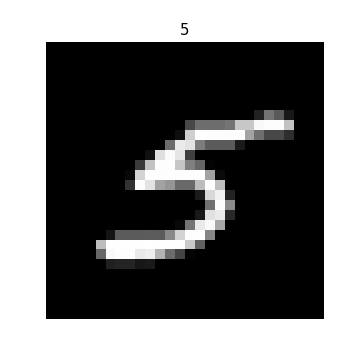

In [3]:
# make train/test splits
m = 60000
X_train, X_test = X[:,:m], X[:,m:]
Y_train, Y_test = Y[:,:m], Y[:,m:]
print(X.shape, Y.shape)

# randomly shuffle trainset
np.random.seed(123456) # for reproducibility
shuffle = np.random.permutation(m)
X_train, Y_train = X_train[:,shuffle], Y_train[:,shuffle]

# visual check
plt.ion()
sample = np.random.randint(m)
fig = plt.figure(figsize = (4,4))
ax1 = fig.add_subplot(111)
ax1.imshow(X_train[:,sample].reshape(28, -1), cmap = 'binary_r')
ax1.axis('off')
ax1.set_title(np.argmax(Y_train[:,sample]))
fig.canvas.draw()


<IPython.core.display.Javascript object>


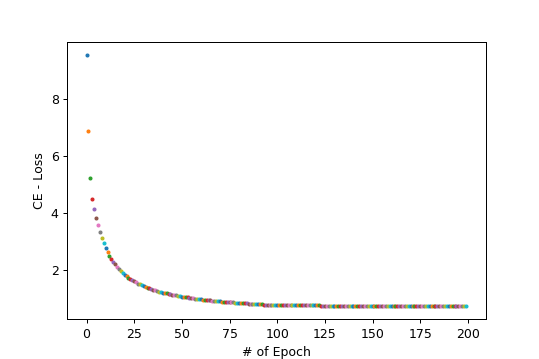

In [4]:
# implement 3 layers mlp

# define network: 
n_samples = 60000
input_dims = 784
hidden_dims = 64
output_dims = 10
epochs = 200

# initialize weights/bias
W1 = np.random.randn(hidden_dims, input_dims) # 128 * 784
W2 = np.random.randn(output_dims, hidden_dims) # 10 * 128
b1 = np.zeros((hidden_dims, 1)) # 128 * 1
b2 = np.zeros((output_dims, 1)) # 10 * 1

# train network & plot
Losses = []
fig = plt.figure(figsize = (6, 4))
ax1 = fig.add_subplot(111)
plt.ion()

for ep in range(epochs):
    if ep == 0: lr = 1
    elif ep == 100: lr = 0.1
    elif ep == 150: lr = 0.01

    # forward pass
    Z1 = W1 @ X_train + b1 # (128, 784) @ (784, 60000) + (128, 1)
    A1 = 1 / (1 + np.exp(-Z1)) # sigmoid: 128 * 60000
    Z2 = W2 @ A1 + b2 # (10, 32) @ (128, 60000) + (10, 1)
    A2 = np.exp(Z2) / np.exp(Z2).sum(axis = 0) # 10 * 60000, prob for each class

    # calculate loss
    Loss = -np.sum(Y_train * np.log(A2))/n_samples # scaler
    Losses.append(Loss)

    # backward pass
    dZ2 = A2 - Y_train # 10 * 60000, dL/dZ2 = Y_hat - Y (square-error-like)
    dW2 = dZ2 @ A1.T / n_samples # (10,60000) @ (10, 128).T / 60000
    db2 = dZ2.sum(axis = 1, keepdims = True)/n_samples # (10, 1) <== (10, 60000).sum(axis = 1, keepdims= True)

    dA1 = W2.T @ dZ2 # (10 * 784).T @ (10, 60000) ==> (784, 60000)
    dZ1 = dA1 * A1 * (1 - A1) # d_sigmoid
    dW1 = dZ1 @ X_train.T / n_samples
    db1 = dZ1.sum(axis=1, keepdims = True)/n_samples

    # update W/b
    W1 -= lr * dW1
    W2 -= lr * dW2
    b1 -= lr * db1
    b2 -= lr * db2

    # if ep % 100 == 0: print('Epoch %2d : %.5f'%(ep, Loss))
    # plot losses
    ax1.scatter(ep, Loss, s = 5)
    ax1.set_xlabel('# of Epoch')
    ax1.set_ylabel('CE - Loss')
    fig.canvas.draw() 


In [5]:
# test network
Z1 = W1 @ X_test + b1
A1 = 1/(1+np.exp(-Z1))
Z2 = W2 @ A1 + b2
A2 = np.exp(Z2)/np.exp(Z2).sum(axis = 0) # 10 * 60000

preds = np.argmax(A2, axis = 0) # 10 * 10000
truth = np.argmax(Y_test, axis = 0) # 10 * 10000

In [6]:
# print accuracy
print('accuracy score')
print(accuracy_score(truth, preds))

accuracy score
0.7665


In [7]:
print('confusion matrix')
print(confusion_matrix(truth,preds))

confusion matrix
[[ 845    0   23    5    6   36   23   11   25    6]
 [   0 1067   15   13    1    8    2    4   23    2]
 [  40   28  717   42   28   19   39   27   71   21]
 [  16    8   37  740   13  105   11    9   45   26]
 [   6    8   28   12  720   13   30    8   40  117]
 [  33   19   17  110   18  570   27   18   60   20]
 [  20    5   36    5   27   19  816    3   16   11]
 [  14   30   24   10   25    1    2  815   36   71]
 [  35   15   32   49   35   72   15   21  653   47]
 [  13   12   20   26  126   18    6   43   23  722]]


In [8]:
print('classification report')
print(classification_report(truth, preds))

classification report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       980
           1       0.90      0.94      0.92      1135
           2       0.76      0.69      0.72      1032
           3       0.73      0.73      0.73      1010
           4       0.72      0.73      0.73       982
           5       0.66      0.64      0.65       892
           6       0.84      0.85      0.85       958
           7       0.85      0.79      0.82      1028
           8       0.66      0.67      0.66       974
           9       0.69      0.72      0.70      1009

    accuracy                           0.77     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.77      0.77      0.77     10000

